<a href="https://www.advfn.com/nasdaq/nasdaq.asp?companies=A">Nasdaq Stocks</a>

In [1]:
from datetime import datetime, timedelta
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
with open('../data/all_symbols.pkl', 'rb') as f:
    all_symbols = pickle.load(f)
    
len(all_symbols)

11032

In [3]:
def prepare_batches(all_symbols, batch_size=100):
    n = len(all_symbols)
    batches = []
    batch_start = 0
    batch_end = min(batch_start + batch_size, n)
    while batch_start < n:
        batches.append(all_symbols[batch_start:batch_end])
        batch_start = batch_end
        batch_end = min(batch_start + batch_size, n)
    return batches

In [4]:
batches = prepare_batches(all_symbols)

In [5]:
states = pd.read_csv('../data/hmm_exp_returns.csv')
states = states[['Date', 'state']]
states.index = pd.to_datetime(states.Date)
states.drop(columns='Date', inplace=True)
states.head()

,state
Date,
1970-01-02,0
1970-01-05,0
1970-01-06,0
1970-01-07,0
1970-01-08,0


In [6]:
states.state.value_counts()

3    2178
1    2113
6    2102
5    1872
0    1747
2    1234
4    1067
7    1003
Name: state, dtype: int64

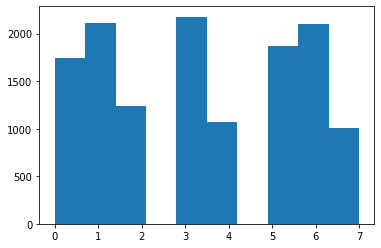

In [7]:
plt.hist(states.state);

In [8]:
STATES = sorted(states.state.unique())
STATES

[0, 1, 2, 3, 4, 5, 6, 7]

In [9]:
CURRENT_STATE = states.state.to_numpy()[-1]
CURRENT_STATE

1

In [10]:
RUN = {
    0: 'all',
    1: 0,  # specific batch
    2: 'random_batch'
}[0]
MIN_OVERALL_SHARPE = 0.45
MIN_STOCK_PRICE = 1.00

In [11]:
if RUN == 'random_batch':
    n_batches = len(batches)
    idx = np.random.randint(0, n_batches)
    run_batches = [batches[idx]]
elif isinstance(RUN, int):
    run_batches = [batches[RUN]]
else:
    run_batches = batches
    
print('n batches:', len(run_batches))

n batches: 111


In [12]:
TODAY = (datetime.now() + timedelta(1)).date()
YEARS_OF_DATA = 50
MIN_YEARS = 10
START = TODAY - timedelta(YEARS_OF_DATA * 365)
min_start = TODAY - timedelta(MIN_YEARS * 365)
if min_start.weekday() == 0:
    min_start -= timedelta(2)
elif min_start.weekday() == 6:
    min_start -= timedelta(1)
START, TODAY, min_start, min_start.weekday()

(datetime.date(1972, 10, 27),
 datetime.date(2022, 10, 15),
 datetime.date(2012, 10, 17),
 2)

In [13]:
START, TODAY

(datetime.date(1972, 10, 27), datetime.date(2022, 10, 15))

In [14]:
def download_data(symbols):
    std_out = sys.stdout
    null = open(os.devnull, 'w')
    sys.stdout = null
    try:
        data = (
            yf
            .download(symbols, start=START, end=TODAY)
            .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']
        data.index = pd.to_datetime(data.index)
        data = data.sort_index()
        data = data.loc[:, data.isnull().sum() != len(data)]
        missing_last = [
            col for col in list(data) if data[col].isnull()[-1]]
        data.drop(columns=missing_last, inplace=True)
        sys.stdout = std_out
        return data
    except BaseException as e:
        print(f'Failed to download data:\n{e}')

In [15]:
def adjust_min_date(min_date, dates):
    while pd.to_datetime(min_date) not in dates:
        min_date -= timedelta(1)
    return min_date

In [16]:
def filter_by_min_date(data, min_date):
    for col in data.columns:
        #if np.isnan(data.at[pd.to_datetime(min_date), col]):
        #    data.drop(columns=[col], inplace=True)
        if (
                data[col][data[col].notnull()].index[0] 
                > pd.to_datetime(min_date)):
            data.drop(columns=[col], inplace=True)
    return data

In [17]:
def filter_by_min_price(data):
    for col in data.columns:
        if (
                data[col][data[col].notnull()].to_numpy()[-1]
                < MIN_STOCK_PRICE):
            data.drop(columns=[col], inplace=True)
    return data

In [18]:
def get_daily_returns(x):
    idx = x.index
    n = len(x)
    x = np.array(x)
    returns = x[1:n] / x[0:(n-1)] - 1
    returns = pd.Series(returns, index=idx[1:])
    return returns

In [19]:
def get_sharpe(returns, window=None):
    n = len(returns)
    if window is None:
        window = n
    if len(returns) > window:
        returns = returns[(n - window):n]
    returns = returns[~np.isnan(returns)]
    sharpe = (np.sqrt(252) * returns.mean()) / returns.std()
    return sharpe

In [20]:
def get_sharpes_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        sharpe = get_sharpe(returns)
        stock_data.append(sharpe)
        for state in STATES:
            sharpe_state = get_sharpe(returns[data.state == state])
            stock_data.append(sharpe_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['sharpe'] + [f'sharpe_{state}' for state in STATES],
        index=stocks)
    return df_out

In [21]:
def get_annualized_daily_return(returns):
    #s_returns = returns[data.state == 0]
    returns = np.array([1] + list((returns[returns.notnull()] + 1).to_numpy()))
    amt = returns.cumprod()
    n = len(returns)
    daily_return = amt[-1]**(1/(n - 1))
    return daily_return

In [22]:
def get_daily_annualized_return_by_state(data):
    output = []
    stocks = [col for col in list(data) if col != 'state']
    for stock in stocks:
        stock_data = []
        returns = get_daily_returns(data[stock])
        annualized_daily_return = get_annualized_daily_return(returns)
        stock_data.append(annualized_daily_return)
        for state in STATES:
            daily_annualized_return_state = get_annualized_daily_return(
                returns[data.state == state])
            stock_data.append(daily_annualized_return_state)
        output.append(stock_data)
    df_out = pd.DataFrame(
        output,
        columns=['dar'] + [f'dar_{state}' for state in STATES],
        index=stocks)
    return df_out

In [23]:
def best_n_by_state(df, n, state):
    candidates = df[df.sharpe >= MIN_OVERALL_SHARPE]
    return (
        candidates
        .sort_values(f'sharpe_{state}', ascending=False)
        .index[:n])

In [24]:
def process_batch(batch, min_start):
    data = download_data(batch)
    min_start = adjust_min_date(min_start, data.index)
    data = filter_by_min_date(data, min_start)
    data = filter_by_min_price(data)
    data = pd.concat([data, states], axis=1).loc[data.index, :]
    #state_sharpes = get_sharpes_by_state(data)
    #return state_sharpes
    state_dars = get_daily_annualized_return_by_state(data)
    return state_dars

In [25]:
dfs = []
print('Beginning batch:')
for batch in batches:
    print(batch[0], end=' ')
    df = process_batch(batch, min_start)
    dfs.append(df)

Beginning batch:
A ACER ADXS AHAC ALJJ AMOT APEN ARII ASVI AVCO BAH BDJ BIE BLTI BR BTI CACQ CBNK CDTX CGFW CIT CLWT CNVX CPLG CSBR CUBI CYPB DEA DLGC DRIO DXCM EE 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_19830/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


EMBC EPM ETR EZGO FE FIV FNVT FSLA FXJP GENI GLBC GOAM GSM HBCP HGLB HOG HTRN ICAB IGU INHO IPVI 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_19830/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


IVR JMSB KERX KRMD LCA LIN LPI LYV MCD MERX MIR MNTK MS MUE NAV NETI NM NRDS NURO 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_19830/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


NYXH OLLI ORCL PACX PCX PGHD PLL POWW PSAG PXMD RADI RENT RLTY RRI SAGA SCLN 

/var/folders/41/jhvt_zmd3nz3x5jsqblr221r0000gn/T/ipykernel_19830/2754352466.py:6: RuntimeWarning: invalid value encountered in double_scalars
  daily_return = amt[-1]**(1/(n - 1))


SFLY SILV SMMC SOLO SRCH STJ SWBD TBBK TFC TLEO TPPP TSHA TYDE UNFI VAC VINT VQS VYNE WGO WRE XENE YDKN ZOM 

In [26]:
df = pd.concat(dfs, axis=0)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
A,1.000267,0.994740,1.000759,1.000834,0.989075,1.001245,1.001847,1.001881,1.015513
AA,1.000254,0.993978,1.000607,1.000824,1.001982,1.000690,1.001239,1.001123,1.000855
AAIC,0.999484,0.992217,1.000777,1.002304,0.998700,1.000809,1.000948,0.999933,1.017785
AAL,0.999924,0.994120,0.998838,1.002931,0.999369,1.001256,1.000376,1.001912,1.021618
AAME,0.999978,0.995875,1.000227,1.001080,1.000911,1.000314,1.001190,1.000026,1.001472


In [27]:
df.tail()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7
ZTEK,1.000513,0.997061,0.997824,0.998971,0.988371,1.006918,1.002235,0.998408,1.038174
ZTR,1.000181,0.998320,1.000027,1.000423,1.000544,1.000627,1.000671,1.000681,1.001146
ZUMZ,1.000121,0.995101,0.999365,1.001944,0.975295,1.000912,1.001475,1.001711,1.003438
ZWS,1.000067,0.993240,0.999965,0.999693,0.992859,1.000028,1.001992,1.001551,1.019815
ZYXI,1.000409,0.998150,1.001297,0.999206,0.979374,1.001248,0.997961,1.002650,1.020438


In [28]:
df.to_csv('../data/sharpes_by_state.csv', index=True)

In [29]:
df = pd.read_csv('../data/sharpes_by_state.csv', index_col=0)

In [30]:
CURRENT_STATE# = 0

1

In [31]:
# Weighted Best
# 3: 0.2, 0.6, 0.2
# 2: 0.6, 0.4
#df['weighted'] = {
#    0: 0.6*df.sharpe_0 + 0.4*df.sharpe_1,
#    1: 0.2*df.sharpe_0 + 0.6*df.sharpe_1 + 0.2 * df.sharpe_2
#}[CURRENT_STATE]

df['weighted'] = {
    0: (0.7*df[f'dar_{CURRENT_STATE}'] 
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.2*df.dar),
    1: (0.6*df[f'dar_{CURRENT_STATE}']
        + 0.1*df[f'dar_{CURRENT_STATE + 1}']
        + 0.1*df[f'dar_{CURRENT_STATE - 1}']
        + 0.2*df.dar)
}[CURRENT_STATE]

df = df.sort_values('weighted', ascending=False)
df.head()

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
ELC,1.001303,0.997657,1.008391,0.996139,1.000000,1.000158,1.002259,1.000906,0.989022,1.004675
GGE,1.000665,0.993427,1.005443,1.000178,0.990182,1.002594,1.001148,1.000244,0.975423,1.002759
LFMD,1.000390,0.997516,1.003876,1.000142,1.057236,1.001523,0.998818,0.999252,0.990694,1.002169
FSI,1.001276,0.999927,1.002665,1.000332,1.018281,1.000896,1.000743,1.001277,1.021142,1.001880
COOP,1.000483,0.995790,1.003118,0.999934,0.996222,1.001854,1.001568,0.998883,1.022545,1.001540


In [32]:
df.mean(), df.median()

(dar         1.000154
 dar_0       0.996165
 dar_1       1.000126
 dar_2       1.000877
 dar_3       0.997582
 dar_4       1.000982
 dar_5       1.001142
 dar_6       1.000931
 dar_7       1.008738
 weighted    0.999809
 dtype: float64,
 dar         1.000245
 dar_0       0.996304
 dar_1       1.000271
 dar_2       1.000857
 dar_3       1.000481
 dar_4       1.001004
 dar_5       1.001151
 dar_6       1.000914
 dar_7       1.007143
 weighted    0.999997
 dtype: float64)

In [42]:
exclude = {
    0: [
        'ABST', 'AGI', 'AMEH', 'APT', 'BGS', 'CZFS', 'ELC', 'ESOA',
        'FNV', 'FSI', 'GCBC', 'GME', 'IDR', 'MTA', 'OLB', 'SVFD', 'WTRG'
    ],
    1: [
        'DTST', 'ELC', 'FSI', 'MOBQ']}

In [43]:
best_weighted = [
    s for s in df.index if s not in exclude[CURRENT_STATE]
][:20]
#sorted(best_weighted)

In [44]:
print(sorted(best_weighted))

['AMRC', 'AMZN', 'COOP', 'CSIQ', 'CTSH', 'CVE', 'ENPH', 'EPSN', 'FKWL', 'GCBC', 'GGB', 'GGE', 'LFMD', 'NTAP', 'PACB', 'SNEX', 'SOBR', 'TJX', 'UTHR', 'VTSI']


In [45]:
df.loc[best_weighted]

,dar,dar_0,dar_1,dar_2,dar_3,dar_4,dar_5,dar_6,dar_7,weighted
GGE,1.000665,0.993427,1.005443,1.000178,0.990182,1.002594,1.001148,1.000244,0.975423,1.002759
LFMD,1.000390,0.997516,1.003876,1.000142,1.057236,1.001523,0.998818,0.999252,0.990694,1.002169
COOP,1.000483,0.995790,1.003118,0.999934,0.996222,1.001854,1.001568,0.998883,1.022545,1.001540
ENPH,1.001312,0.991877,1.003569,0.998989,0.985595,1.000830,1.002436,1.003891,1.004632,1.001490
CVE,1.001426,0.995555,1.000208,1.014552,0.975895,1.000269,1.000642,1.000184,1.026051,1.001421
FKWL,1.000092,0.996339,1.003080,0.998811,1.000000,1.000045,1.000481,0.999461,1.019448,1.001381
EPSN,1.000134,0.995540,1.002641,1.001661,1.009452,1.000119,1.000285,0.999853,1.004442,1.001332
CSIQ,1.000164,0.988824,1.004059,0.999009,0.978913,1.002102,1.003372,1.000767,1.020067,1.001251
AMRC,1.000584,0.992184,1.003316,0.999170,0.994350,1.002244,1.000979,1.001917,1.019093,1.001242
AMZN,1.001094,0.996002,1.001942,1.001816,0.989760,1.002434,1.002262,1.001924,1.014130,1.001166


In [46]:
data = (
    yf
    .download(best_weighted, start=START, end=TODAY)
    .rename(columns={'Adj Close': 'AdjClose'}))['AdjClose']

[*********************100%***********************]  20 of 20 completed


In [47]:
data.index = pd.to_datetime(data.index)
data = data.sort_index()
data.tail()

,AMRC,AMZN,COOP,CSIQ,CTSH,CVE,ENPH,EPSN,FKWL,GCBC,GGB,GGE,LFMD,NTAP,PACB,SNEX,SOBR,TJX,UTHR,VTSI
Date,,,,,,,,,,,,,,,,,,,,
2022-10-10,62.349998,113.669998,42.750000,33.200001,58.150002,17.670000,258.179993,6.54,2.87,56.959999,4.92,2.27,2.12,64.040001,5.74,85.309998,2.82,64.330002,205.949997,5.480
2022-10-11,62.500000,112.209999,42.849998,31.770000,57.220001,17.120001,255.800003,6.55,2.97,56.650002,4.93,2.07,2.16,62.060001,5.67,86.230003,2.52,64.360001,211.479996,5.240
2022-10-12,62.240002,112.900002,43.180000,30.480000,56.750000,17.160000,248.130005,6.47,3.02,57.590000,4.83,2.22,2.10,62.330002,6.41,85.910004,2.56,63.880001,211.250000,5.268
2022-10-13,63.299999,112.529999,43.650002,30.889999,58.950001,17.770000,248.699997,6.57,2.95,58.009998,4.93,2.41,2.18,64.110001,6.54,89.230003,3.05,65.180000,213.759995,5.060
2022-10-14,61.459999,106.900002,42.360001,30.200001,58.599998,16.580000,237.869995,6.50,2.99,57.889999,4.75,2.09,2.12,62.410000,6.10,86.650002,3.00,63.549999,216.440002,5.020


In [48]:
data = pd.concat([data, states], axis=1)

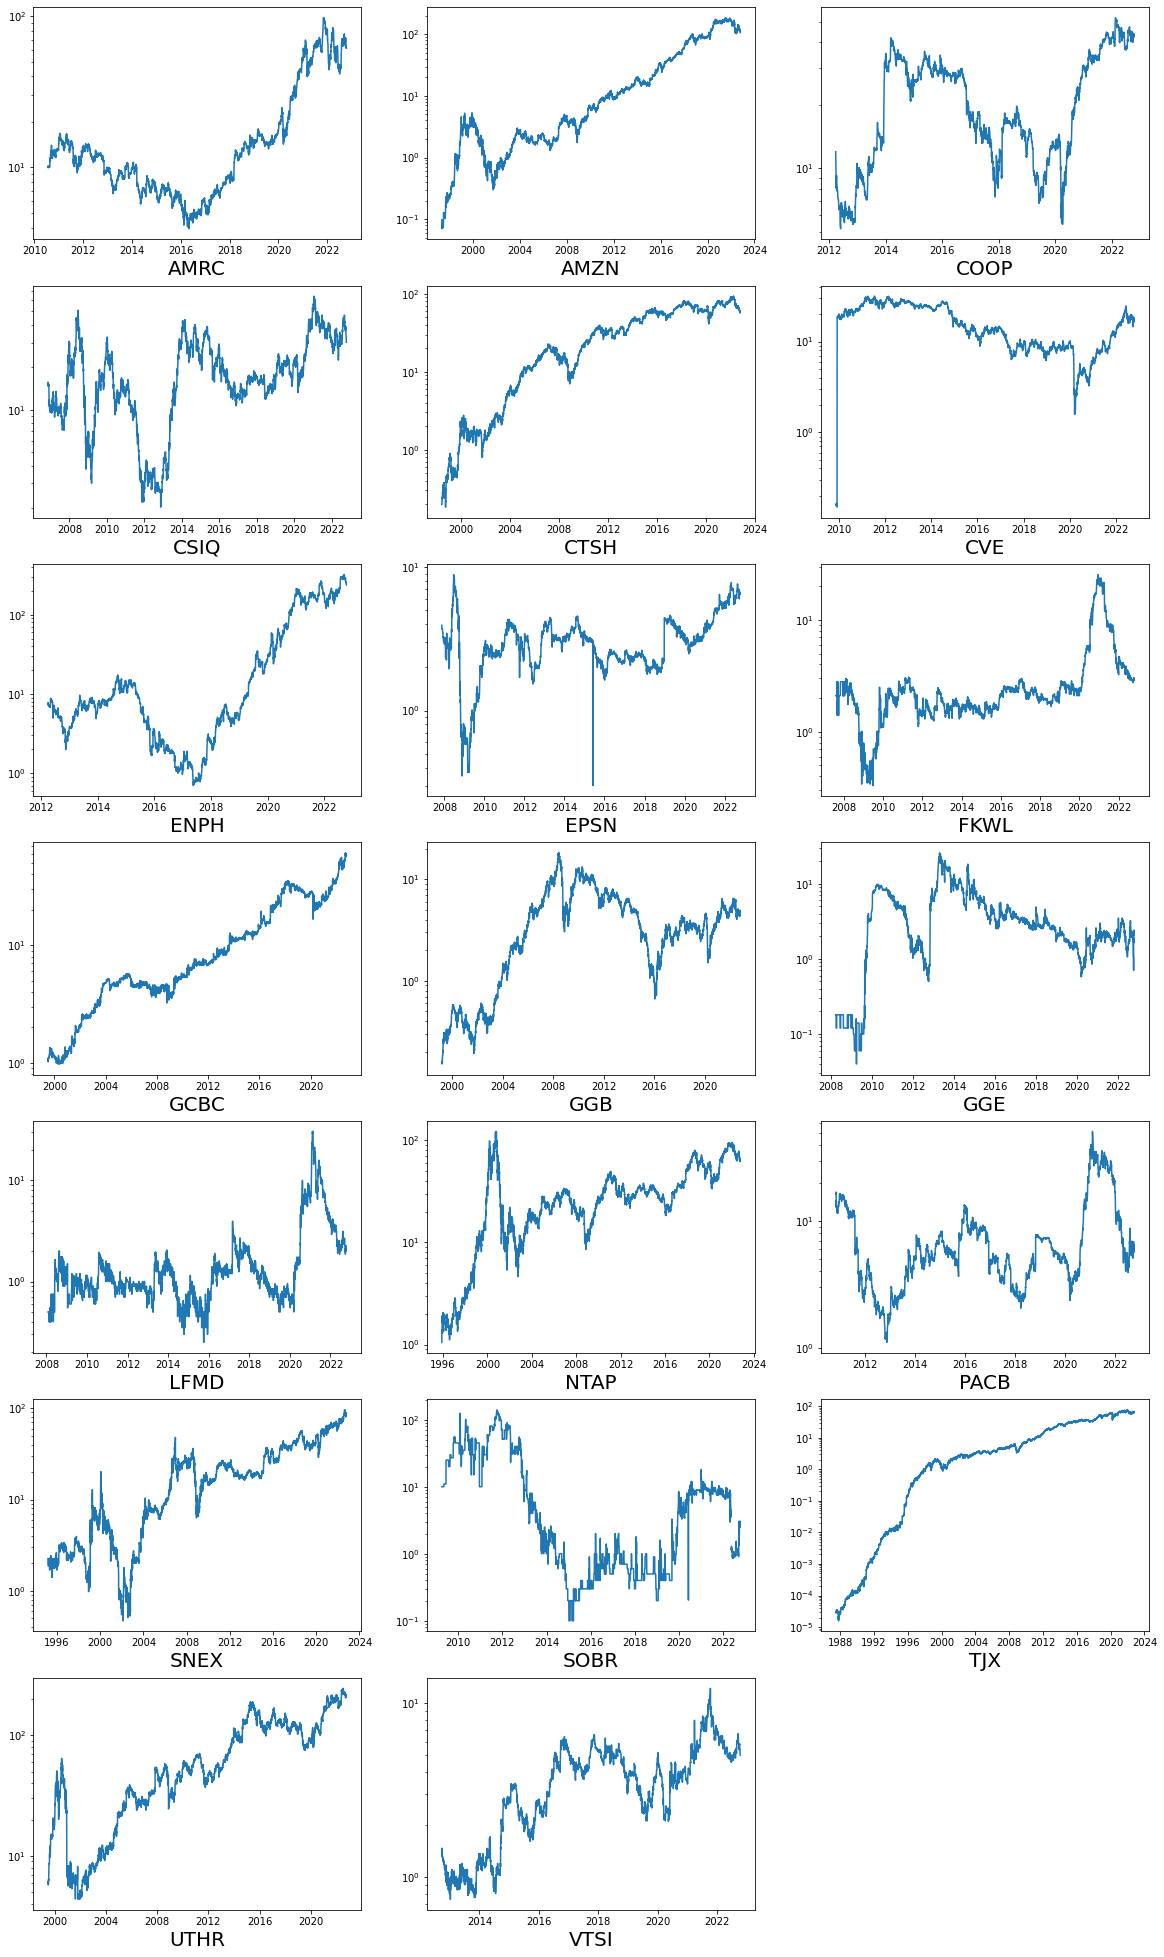

In [49]:
plt.rc('axes', labelsize=20)
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    plt.plot(data[sym])
    plt.xlabel(sym)
    plt.yscale('log');

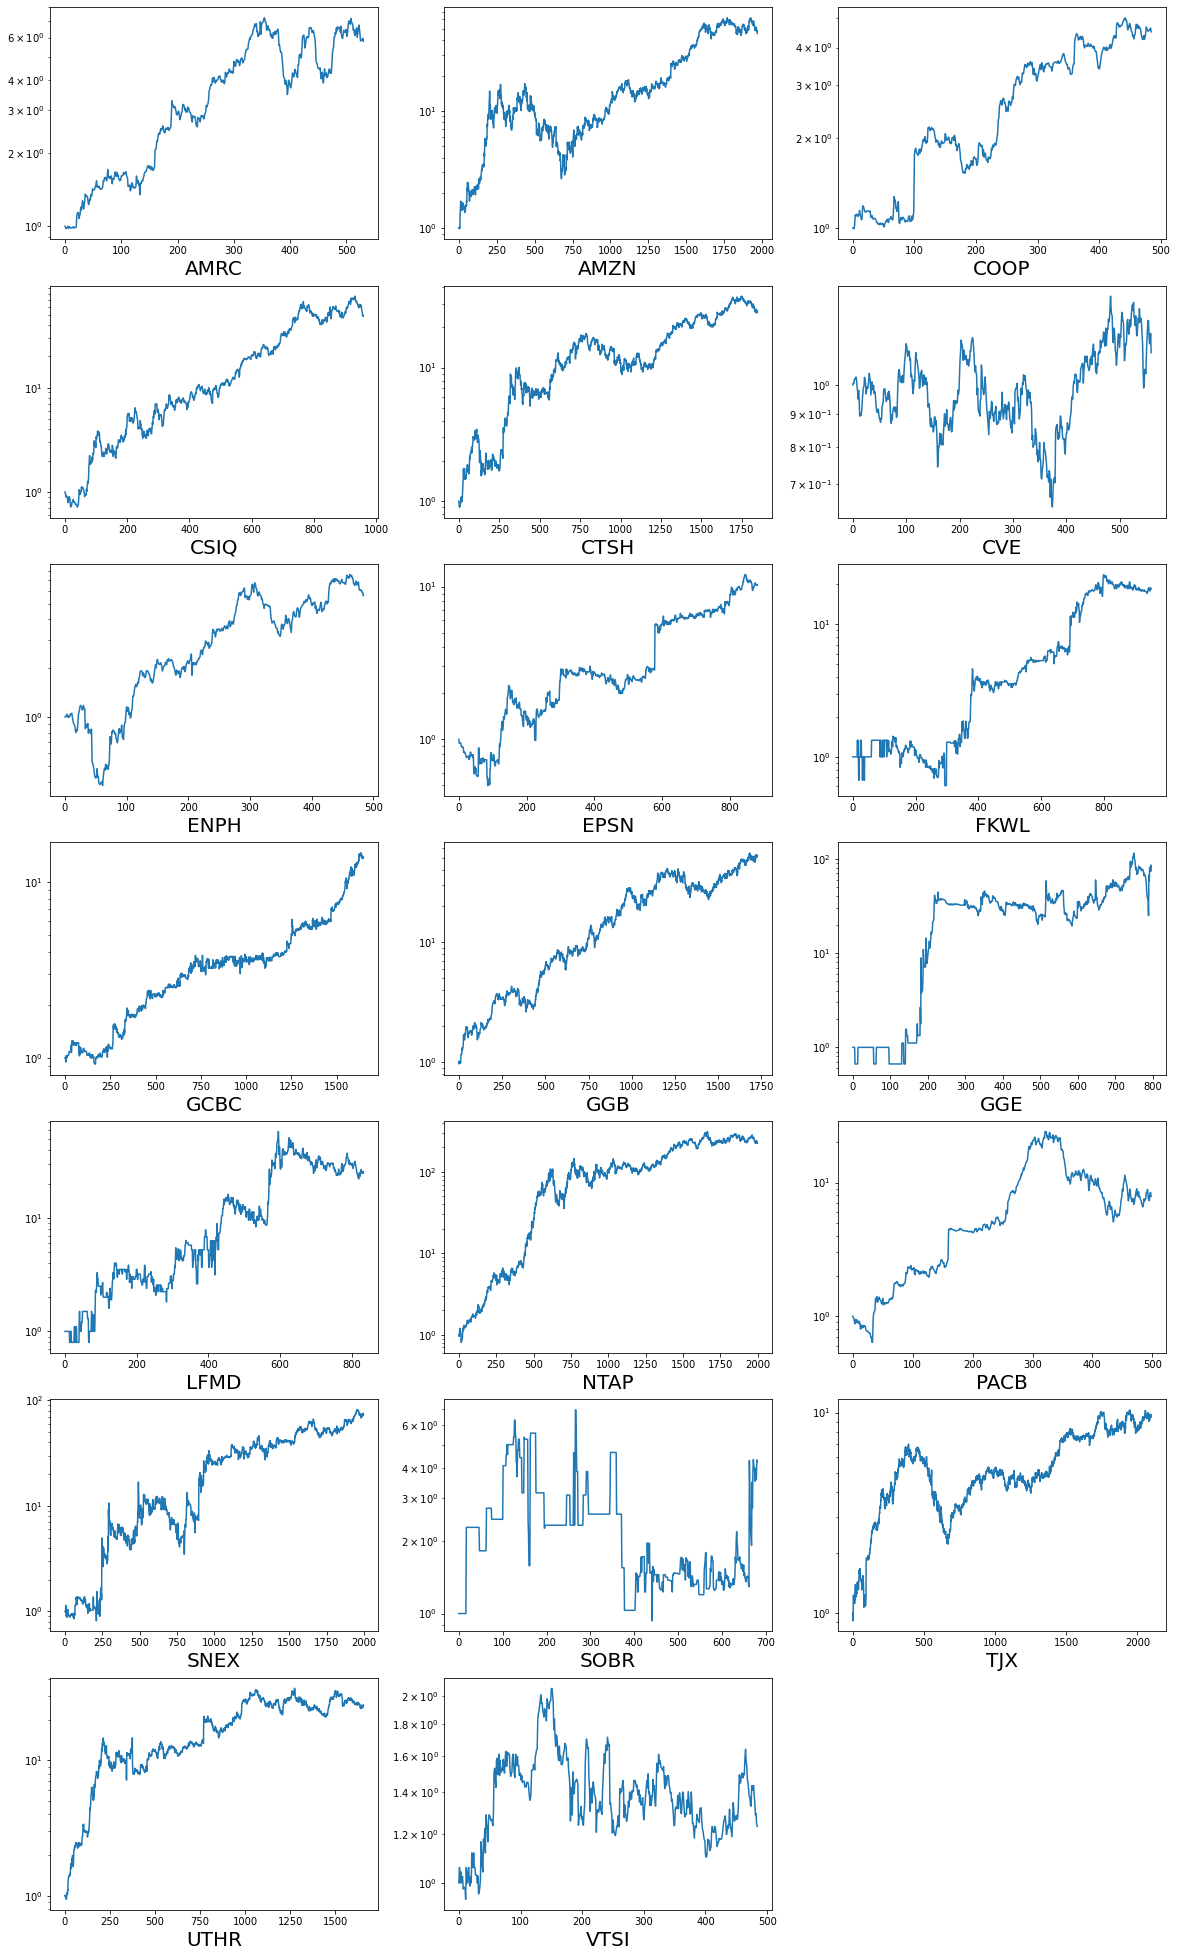

In [50]:
plt.figure(figsize=[20, 35])
for i, sym in enumerate(list(data)):
    if sym == 'state':
        continue
    plt.subplot(7, 3, i + 1)
    dr = get_daily_returns(data[sym])
    dr = dr[data.state == CURRENT_STATE]
    dr = dr[dr.notnull()]
    dr = (dr + 1).to_numpy()
    dr = np.array([1] + list(dr))
    plt.plot(dr.cumprod())
    plt.yscale('log')
    plt.xlabel(sym);

In [40]:
#for stock in df_out.index:
#    if stock in big_df.index:
#        big_df.loc[stock, :] = big_df.loc[stock, :]
#    else:
#        big_df = pd.concat(
#            [big_df, pd.DataFrame(df_out.loc[stock, :]).T], axis=0)
#print(big_df.shape)
#big_df.head()